In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import coint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from numpy.random import normal


In [3]:
from AFML_module.dataset_utilities import (get_instrument_attributes, 
                                           form_dollar_bars, 
                                           form_time_bars,
                                           form_vol_bars,
                                           reduce_to_active_symbols, 
                                           apply_roll_factors)

from AFML_module.triple_barrier_utilities import (get_daily_rolling_volatility,
                                                  get_vertical_barriers,
                                                  detect_crossed_barriers_for_events)

from AFML_module.fractional_differencing_utilities import (get_frac_diff_series_FW, 
                                                           get_frac_diff_series_EW,
                                                           get_fractionally_differenced_series)


In [75]:
from AFML_module.config import RAW_DATA_DIR

data = pd.read_parquet(RAW_DATA_DIR/"sp_emini_data.parquet", engine="pyarrow")
instrument_frame = pd.read_parquet(RAW_DATA_DIR/"instrument_frame.parquet", engine="pyarrow")

In [76]:
dollar_bars = form_dollar_bars(data, thresh=250*10_000_000, sort=False)
active_only = reduce_to_active_symbols(dollar_bars, instrument_frame)
rolled = apply_roll_factors(active_only, sort=False)

# Exercises

### 5.1

Generate a time series from an IID Gaussian random process. This is a memoryless, stationary series:

(a) Compute the ADF statistic on this series. What is the p-value?

(b) Compute the cumulative sum of the observations. This is a non-stationary
series without memory.
    (i) What is the order of integration of this cumulative series?
    (ii) Compute the ADF statistic on this series. What is the p-value?

(c) Differentiate the series twice. What is the p-value of this over-differentiated
series?

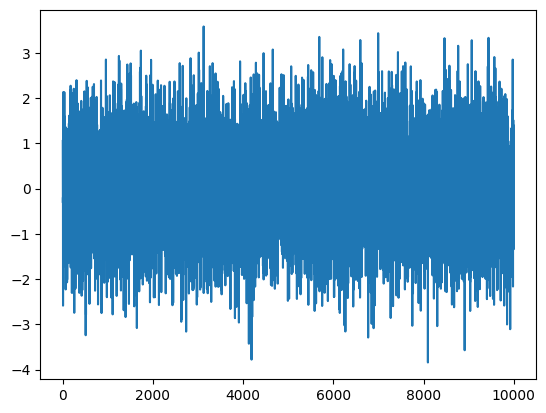

In [9]:
samples = normal(0, 1, 10_000)
plt.plot(samples)

In [13]:
# Recall: ADF tets teh null hypothesis that a unit root is present (implying non-stationary)
adf, pvalue, usedlag, nobs, critival_values, icbest = adfuller(samples)

# p_value low enough to reject the null hypothesis; series is stationary
print(f"ADF Statistic: {adf}, p Value: {pvalue}")

ADF Statistic: -101.84032274346195, p Value: 0.0


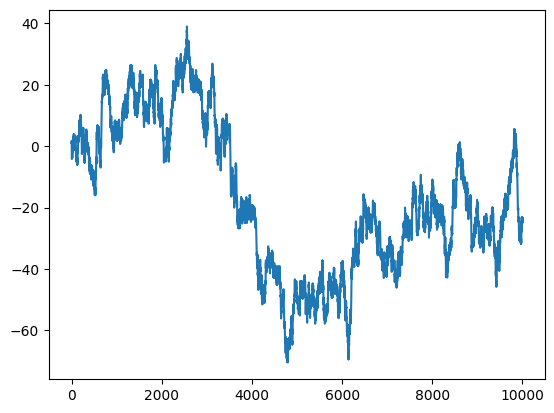

In [14]:
# We compute the cumulative sum of the observations
cumulative_samples = samples.cumsum()
plt.plot(cumulative_samples)

In [15]:
# order of integration is 1.
adf, pvalue, usedlag, nobs, critival_values, icbest = adfuller(cumulative_samples)

# cannot reject null hypothesis, cannot conclude that series is stationary
print(f"ADF Statistic: {adf}, p Value: {pvalue}")

ADF Statistic: -2.0690732286471447, p Value: 0.2571308237607996


ADF Statistic: -27.015405231720926, p Value: 0.0


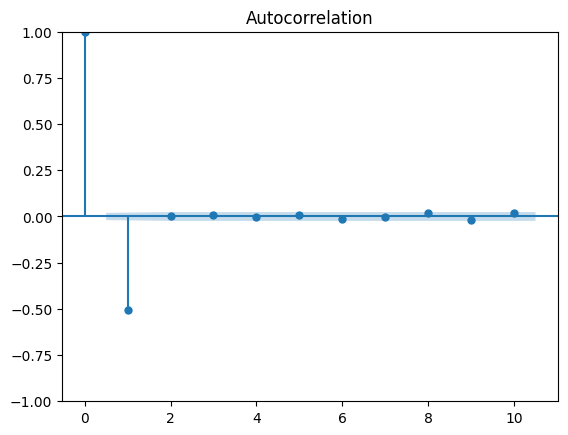

In [19]:
# We test how many how differences are needed to "overdifference"
# It is 2; we see the characteristic autocorrelation at 1 lag with value -0.5

two_diffed = np.diff(np.diff(cumulative_samples))

adf, pvalue, usedlag, nobs, critival_values, icbest = adfuller(two_diffed)
print(f"ADF Statistic: {adf}, p Value: {pvalue}")

plot_acf(two_diffed, lags=10);

### 5.2

Generate a time series that follows a sinusoidal function. This is a stationary
series with memory.

(a) Compute the ADF statistic on this series. What is the p-value?

(b) Shift every observation by the same positive value. Compute the cumulative
sum of the observations. This is a non-stationary series with memory.
(i) Compute the ADF statistic on this series. What is the p-value?
(ii) Apply an expanding window fracdiff, with 𝜏 = 1E − 2. For what minimum d value do you get a p-value below 5%?
(iii) Apply FFD, with 𝜏 = 1E − 5. For what minimum d value do you get a
p-value below 5%?

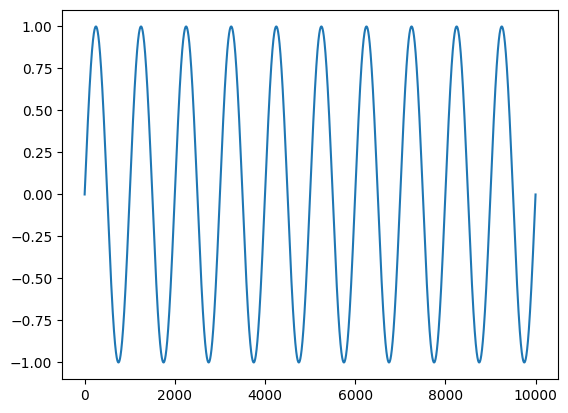

In [22]:
t_grid = np.linspace(0, 10, 10_000)
samples = np.sin(2*np.pi*t_grid)

plt.plot(samples)

In [23]:
# Now check for stationarity
adf, pvalue, usedlag, nobs, critival_values, icbest = adfuller(samples)

# series is stationary
print(f"ADF Statistic: {adf}, p Value: {pvalue}")

ADF Statistic: -615556552658.3953, p Value: 0.0


ADF Statistic: -0.8686301231907918, p Value: 0.7981273948929515


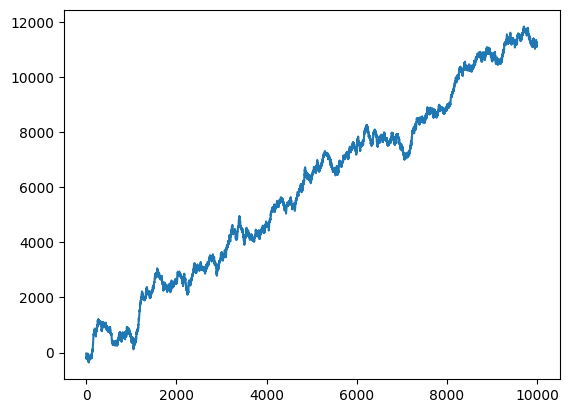

In [26]:
shifted_samples = samples + 1 + np.random.normal(0, 30, samples.shape[0])
cumulative_shifted_samples = shifted_samples.cumsum() 

plt.plot(cumulative_shifted_samples)

adf, pvalue, usedlag, nobs, critival_values, icbest = adfuller(cumulative_shifted_samples)

# Series is not stationary
print(f"ADF Statistic: {adf}, p Value: {pvalue}")

Text(0.5, 0, 'ADF P Value')

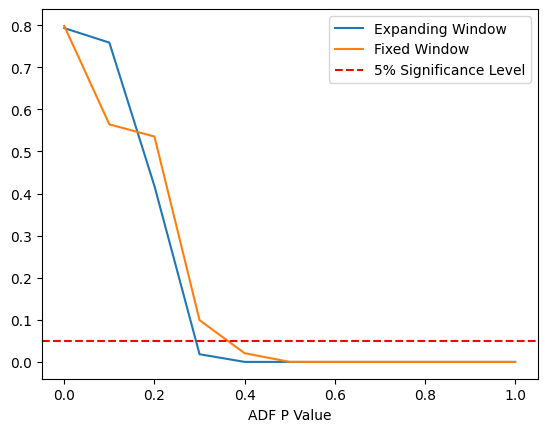

In [35]:
# Using both expanding window Fractional Differencing and Fixed Window Fractional
# differencing, we search for the minimum degree of differencing where the ADF null is rejected

results_EW = []
results_FW = []
search_grid = np.linspace(0, 1, 11)

for d in search_grid:

    frac_diff_series_EW = get_frac_diff_series_EW(d, cumulative_shifted_samples, 1e-2)
    frac_diff_series_FW = get_frac_diff_series_FW(d, cumulative_shifted_samples, 1e-5)
    
    adf, pvalue, usedlag, nobs, critival_values, icbest = adfuller(frac_diff_series_EW)
    results_EW.append([d, adf, pvalue, critival_values["5%"]])
    
    adf, pvalue, usedlag, nobs, critival_values, icbest = adfuller(frac_diff_series_FW)
    results_FW.append([d, adf, pvalue, critival_values["5%"]])

results_EW_frame = pd.DataFrame(results_EW, columns=["d", "adf", "p value", "critical value"])
results_FW_frame = pd.DataFrame(results_FW, columns=["d", "adf", "p value", "critical value"])

plt.plot(search_grid, results_EW_frame["p value"], label="Expanding Window")
plt.plot(search_grid, results_FW_frame["p value"], label="Fixed Window")

plt.axhline(y=0.05, color='r', linestyle='--', label="5% Significance Level")
plt.legend()

plt.xlabel("Degree of Differencing")
plt.xlabel("ADF P Value")

There is a lot of variation from trial to trial, but generally both methods indicated that the time series is stationary for a differencing between 0.1 and 0.4

### 5.4

Take the dollar bar series on E-mini S&P 500 futures. Using the code
in Snippet 5.3, for some d ∈ [0, 2], compute fracDiff_FFD(fracDiff
_FFD(series,d),-d). What do you get? Why?

In [30]:
# To have sufficient data to do this exercise, we'll need to use dollar bars where the returns are not close to normal,
# as then will be sampled more frequently. Will go back to using approximately normal returns in subsequent exercises

temp_dollar_bars = form_dollar_bars(data, thresh=10_000_000, sort=True)
temp_active_only = reduce_to_active_symbols(temp_dollar_bars, instrument_frame)
temp_rolled = apply_roll_factors(temp_active_only, sort=False)

Text(0.5, 1.0, 'Effect of Differencing and Undifferencing for Fixed Window Method')

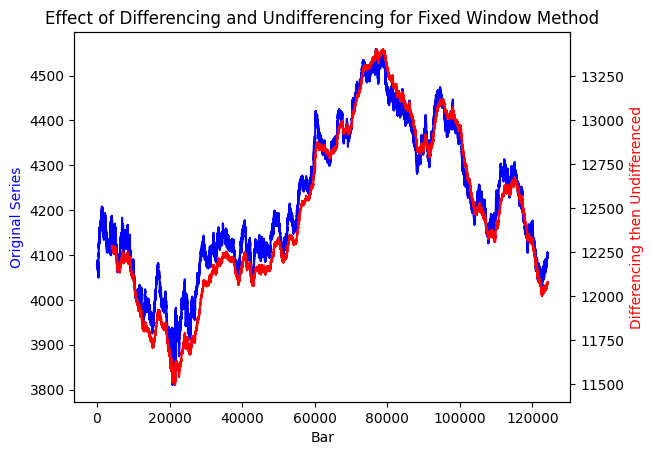

In [41]:
dd = 0.3
tau = 1e-3
diff_undiff = get_frac_diff_series_FW(-dd, get_frac_diff_series_FW(dd, temp_rolled["close"], tau), tau)

fig, ax1 = plt.subplots()

x = np.arange(temp_rolled["close"].shape[0])


ax1.plot(x, temp_rolled["close"], color='blue')
ax1.set_xlabel('Bar')
ax1.set_ylabel('Original Series', color='blue')

ax2 = ax1.twinx()
ax2.plot(x[-diff_undiff.shape[0]:], diff_undiff, color='red')
ax2.set_ylabel('Differencing then Undifferenced', color='red')

ax1.set_title("Effect of Differencing and Undifferencing for Fixed Window Method")

We recover the basic shape of the signal. There is some vertical shift, which is not suprising, since this information is lost by differencing and undifferencing. Also, we lose high frequency information, which again is not suprising because the fixed window differencing cuts out of a lot high frequency information when the weights are truncated


Text(0.5, 1.0, 'Effect of Differencing and Undifferencing--No Thresholding')

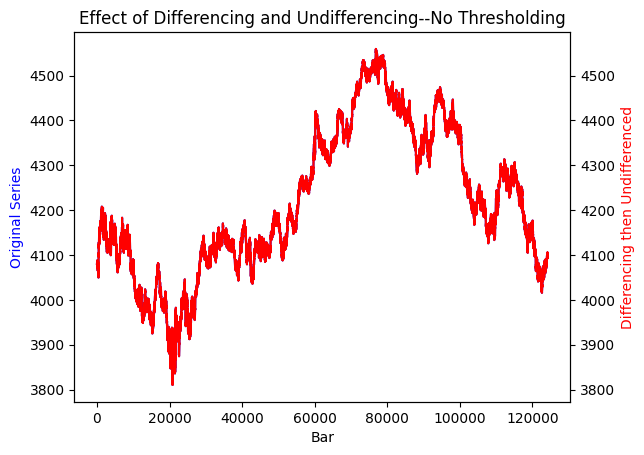

In [46]:
# Now try with no thresholding

dd = 0.7
diff_undiff = get_fractionally_differenced_series(-dd, get_fractionally_differenced_series(dd, temp_rolled["close"]))

fig, ax1 = plt.subplots()

x = np.arange(temp_rolled["close"].shape[0])

ax1.plot(x, temp_rolled["close"], color='blue')
ax1.set_xlabel('Bar')
ax1.set_ylabel('Original Series', color='blue')

ax2 = ax1.twinx()
ax2.plot(x[-diff_undiff.shape[0]:], diff_undiff, color='red')
ax2.set_ylabel('Differencing then Undifferenced', color='red')

ax1.set_title("Effect of Differencing and Undifferencing--No Thresholding")

Alternataively, if we don't do fixed window, we find that the operations are very very close to being true inverses

# 5.5

Take the dollar bar series on E-mini S&P 500 futures.
(a) Form a new series as a cumulative sum of log-prices.

(b) Apply FFD, with 𝜏 = 1E − 5. Determine for what minimum d ∈ [0, 2] the
new series is stationary.

(c) Compute the correlation of the fracdiff series to the original (untransformed)
series.

(d) Apply an Engel-Granger cointegration test on the original and fracdiff series.
Are they cointegrated? Why?

(e) Apply a Jarque-Bera normality test on the fracdiff series.

/var/folders/by/7cbzhksj7t3d6f129n8csbb00000gn/T/ipykernel_74167/1659726960.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, lags, crit = kpss(frac_diff_series)
/var/folders/by/7cbzhksj7t3d6f129n8csbb00000gn/T/ipykernel_74167/1659726960.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pvalue, lags, crit = kpss(frac_diff_series)
/var/folders/by/7cbzhksj7t3d6f129n8csbb00000gn/T/ipykernel_74167/1659726960.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pvalue, lags, crit = kpss(frac_diff_series)
/var/folders/by/7cbzhksj7t3d6f129n8csbb00000gn/T/ipykernel_74167

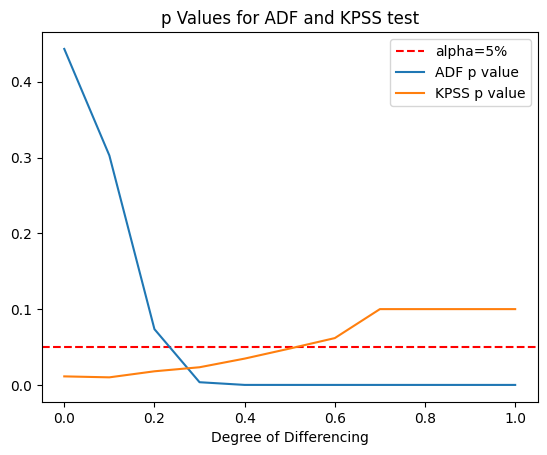

In [78]:
# We will do this exercise on a series of log prices, for d in [0, 1], for a threshold of 1e-3

adf_results = []
kpss_results = []

log_rolled_dollar_bars = np.log(rolled["close"])

for d in np.linspace(0, 1, 11):
    
    frac_diff_series = get_frac_diff_series_FW(d, log_rolled_dollar_bars, 1e-3)
    
    adf, adf_pvalue, usedlag, nobs, critival_values, icbest = adfuller(frac_diff_series)
    kpss_stat, kpss_pvalue, lags, crit = kpss(frac_diff_series)
        
    adf_results.append([d, adf, adf_pvalue, critival_values["5%"], critival_values["10%"]])
    kpss_results.append([d, kpss_stat, kpss_pvalue, crit["5%"]])

    adf_results_frame = pd.DataFrame(adf_results, columns=["d", "adf", "p value", "5%", "10%"])
    kpss_results_frame = pd.DataFrame(kpss_results, columns=["d", "kpss_stat", "p value", "crit"])

# ADF: Null is is that series has unit root (not stationary)
# KPSS: Nulll is that series does not have unit root (is stationary)
# To conclude stationary, need ADF below red dashed line and KPSS above red dashed line

plt.title("p Values for ADF and KPSS test")
plt.axhline(y=0.05, color='r', linestyle='--', label="alpha=5%")
plt.plot(np.linspace(0, 1, 11), adf_results_frame["p value"], label="ADF p value")
plt.plot(np.linspace(0, 1, 11), kpss_results_frame["p value"], label="KPSS p value")
plt.xlabel("Degree of Differencing")
plt.legend();

Text(0.5, 1.0, 'Comparison of Original Log Price Series and Fractionally Difference Series')

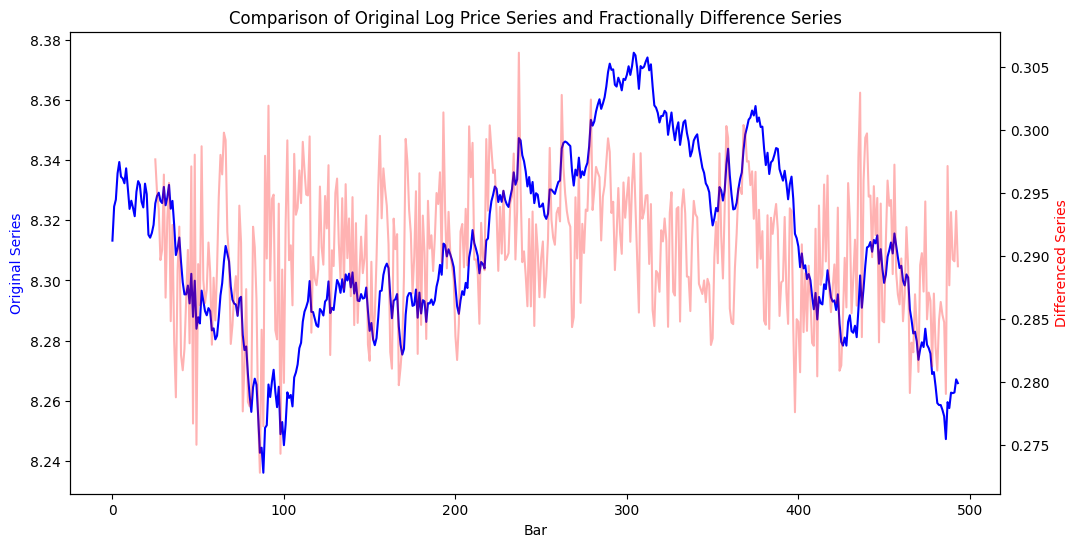

In [99]:
# we conclude that the series is stationary for d ~ 0.7, which looks plausible by eye
# from the plot below

min_d = 0.7
frac_diff_series = get_frac_diff_series_FW(min_d, log_rolled_dollar_bars, 1e-3)
fig, ax1 = plt.subplots(figsize=(12, 6))

x = np.arange(rolled.shape[0])

ax1.plot(x, np.log(rolled["close"]), color='blue')
ax1.set_xlabel('Bar')
ax1.set_ylabel('Original Series', color='blue')

ax2 = ax1.twinx()
ax2.plot(x[-frac_diff_series.shape[0]:], frac_diff_series, color='red', alpha=0.3)
ax2.set_ylabel('Differenced Series', color='red')

ax1.set_title("Comparison of Original Log Price Series and Fractionally Difference Series")

In [80]:
# Now we check the correlation of the differenced series and the original, undifferenced series
full_diff_series = get_fractionally_differenced_series(1, np.log(rolled["close"]))[1:]

print(f"Correlation for d={min_d}:")
print(np.corrcoef(log_rolled_dollar_bars[-frac_diff_series.shape[0]:], frac_diff_series))

print(f"Correlation for d=1:")
print(np.corrcoef(log_rolled_dollar_bars[-full_diff_series.shape[0]:], full_diff_series))

Correlation for d=0.7:
[[1.         0.37486984]
 [0.37486984 1.        ]]
Correlation for d=1:
[[1.         0.09822049]
 [0.09822049 1.        ]]


The correlation of the fractionally differenced series and the original series is significant, and is much higher than the correlation of the difference series and the original series. This makes sense, as the whole point of the fractional differencing is to preserve as much of the memory that is present in the original series as possible.

In [81]:
# Now we check whether there is a coinintegrated relationship between the original series and the 
# differenced series

t_stat, p_value, crit_value = coint(log_rolled_dollar_bars[-frac_diff_series.shape[0]:], frac_diff_series)

print(f"t statistic: {t_stat}, p value: {p_value}")

t statistic: -1.553446012833215, p value: 0.7401328678331666


Recall that the null hypothesis is that there is no cointegrated relationship. We cannot reject the null, and thus conclude that there is no cointegrated relationship. This makes sense, since the original series is not stationary but the fractionally diffed series is stationary. Thus, there shouldn't be a linear combination of the two which is stationary. Also violates the assumptions of the test, which assumes both series have the same order of integration

,jb_stat,p_value,skewness,kurtosis
0,6.054907,0.048439,-0.273561,2.897513


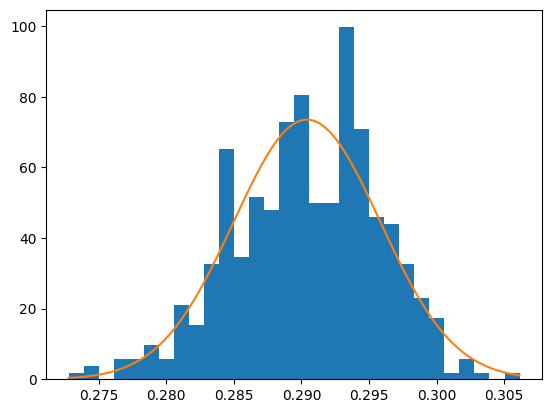

In [82]:
# Now check if resulting fracdiff series has normally distributed values

mean, std = norm.fit(frac_diff_series)
grid = np.linspace(frac_diff_series.min(), frac_diff_series.max(), 10_000)

plt.hist(frac_diff_series, bins=30, density=True);
plt.plot(grid, norm.pdf(grid, loc=mean, scale=std))

jb_stat, p_value, skewness, kurtosis = jarque_bera(frac_diff_series)
pd.DataFrame([[jb_stat, p_value, skewness, kurtosis]], 
                  columns=["jb_stat", "p_value", "skewness", "kurtosis"])

The data is not normally distributed. Previously, we choose the smallest sampling frequency where we would not immediately rule out non-normality on the price differences via the JB test. In the above, we do not even take the first difference, and so it is reasonable that the JB test concludes the data is non-normal

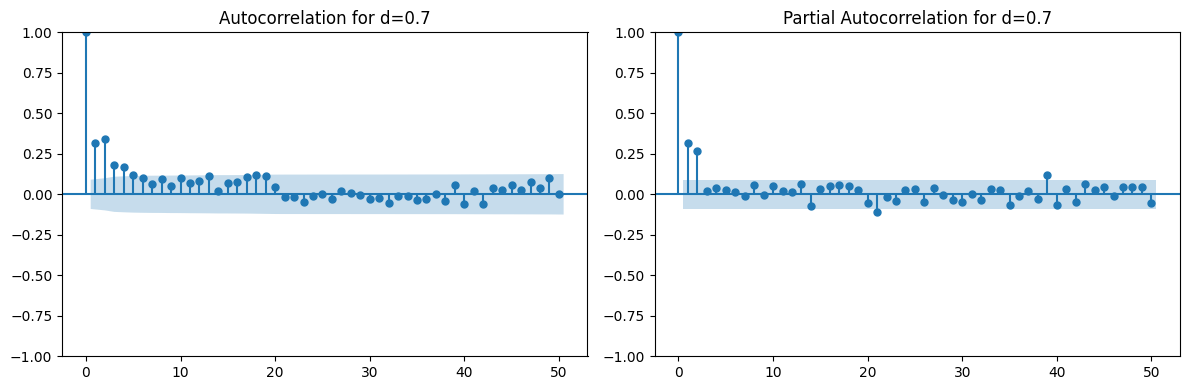

In [83]:
# We can also check the impact on memory preservation:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

plot_acf(frac_diff_series, lags=50, ax=ax1)
plot_pacf(frac_diff_series, lags=50, ax=ax2)

ax1.set_title(f"Autocorrelation for d={min_d}")
ax2.set_title(f"Partial Autocorrelation for d={min_d}")

plt.tight_layout()
plt.show()

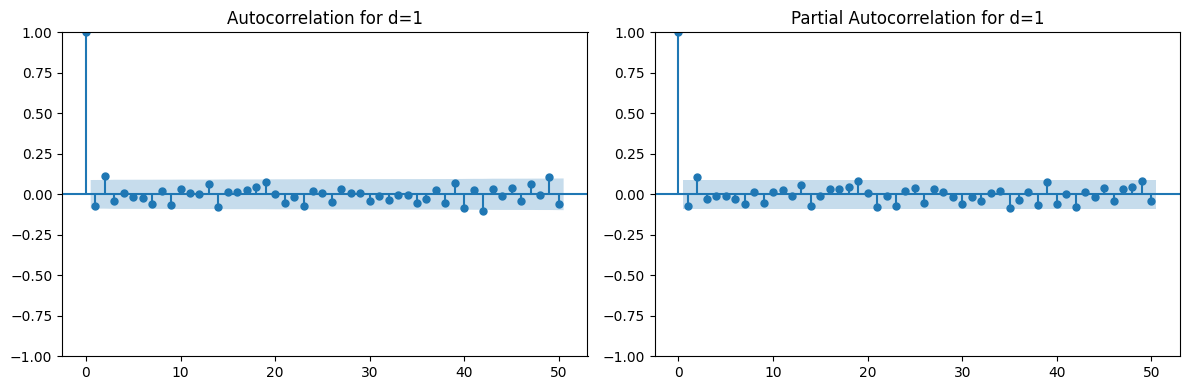

In [84]:
# Now compare this to the fully differenced series
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

plot_acf(full_diff_series, lags=50, ax=ax3);
plot_pacf(full_diff_series, lags=50, ax=ax4);

ax3.set_title("Autocorrelation for d=1");
ax4.set_title("Partial Autocorrelation for d=1");

plt.tight_layout()
plt.show()

Thus, we can see that the fractional differencing succesfully preserves some of the memory of the original price series, 

### Additional Check on Daily S&P Returns over Many Years

In [85]:
import yfinance as yf

ticker = yf.Ticker("SPY")

spy = ticker.history(start="2000-01-01", interval="1d")  
spy.index = spy.index.date
spy.index = pd.to_datetime(spy.index)
spy = spy.drop(["Dividends", "Stock Splits", "Capital Gains"], axis=1)

spy["Return"] = spy["Close"]/spy["Close"].shift(1) - 1
spy = spy.dropna()

/var/folders/by/7cbzhksj7t3d6f129n8csbb00000gn/T/ipykernel_74167/659153019.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, lags, crit = kpss(frac_diff_series)
/var/folders/by/7cbzhksj7t3d6f129n8csbb00000gn/T/ipykernel_74167/659153019.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, lags, crit = kpss(frac_diff_series)
/var/folders/by/7cbzhksj7t3d6f129n8csbb00000gn/T/ipykernel_74167/659153019.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, lags, crit = kpss(frac_diff_series)
/var/folders/by/7cbzhksj7t3d6f129n8csbb00000gn/T/ipykernel_74167/65

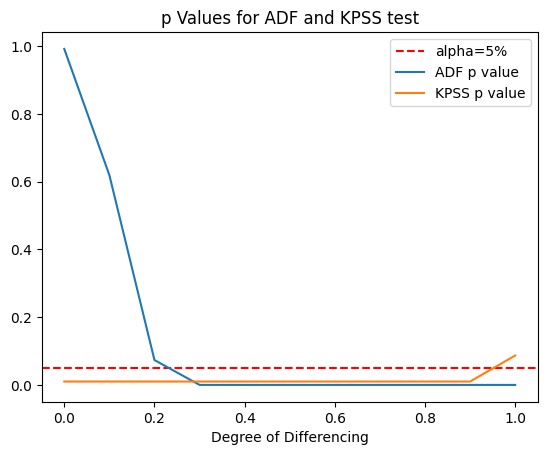

In [86]:
# We will do this exercise on a series of log prices, for d in [0, 1], for a threshold of 1e-3

adf_results = []
kpss_results = []

log_spy_close = np.log(spy["Close"])

for d in np.linspace(0, 1, 11):
    frac_diff_series = get_frac_diff_series_FW(d, log_spy_close, 1e-5)
    
    adf, adf_pvalue, usedlag, nobs, critival_values, icbest = adfuller(frac_diff_series, maxlag=1, regression="c")
    kpss_stat, kpss_pvalue, lags, crit = kpss(frac_diff_series)
    
    adf_results.append([d, adf, adf_pvalue, critival_values["5%"], critival_values["10%"]])
    kpss_results.append([d, kpss_stat, kpss_pvalue, crit["5%"]])

    adf_results_frame = pd.DataFrame(adf_results, columns=["d", "adf", "p value", "5%", "10%"])
    kpss_results_frame = pd.DataFrame(kpss_results, columns=["d", "kpss_stat", "p value", "crit"])

# ADF: Null is is that series has unit root (not stationary)
# KPSS: Nulll is that series does not have unit root (is stationary)
# To conclude stationary, need ADF below red dashed line and KPSS above red dashed line

plt.title("p Values for ADF and KPSS test")
plt.axhline(y=0.05, color='r', linestyle='--', label="alpha=5%")
plt.plot(np.linspace(0, 1, 11), adf_results_frame["p value"], label="ADF p value")
plt.plot(np.linspace(0, 1, 11), kpss_results_frame["p value"], label="KPSS p value")
plt.xlabel("Degree of Differencing")
plt.legend();

Text(0.5, 1.0, 'Comparison of Original Log Price Series and Fractionally Difference Series')

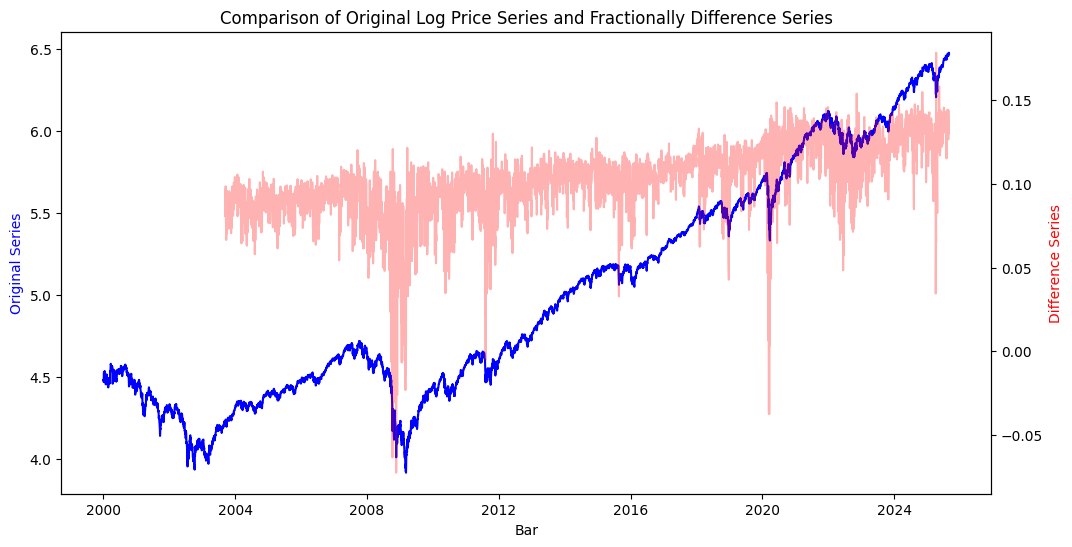

In [107]:
# we conclude that the series is stationary for d ~ 0.3-0.4 (even though KPSS contradicts this). This really doesn't look plausible from
# the plot below, since the differenced series has a clear, gentle trend. The fact that the KPSS test fails is important

min_d = 0.5
frac_diff_series = get_frac_diff_series_FW(min_d, log_spy_close, 1e-5)
fig, ax1 = plt.subplots(figsize=(12, 6))

x = np.arange(log_spy_close.shape[0])

ax1.plot(log_spy_close.index, log_spy_close, color='blue')
ax1.set_xlabel('Bar')
ax1.set_ylabel('Original Series', color='blue')

ax2 = ax1.twinx()
ax2.plot(log_spy_close.index[-frac_diff_series.shape[0]:], frac_diff_series, color='red', alpha=0.3)
ax2.set_ylabel('Difference Series', color='red')

ax1.set_title("Comparison of Original Log Price Series and Fractionally Difference Series")